In [1]:
import mne
import nibabel as nb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyedflib
from mne.io.constants import FIFF


In [2]:
def readRegMatrix(trsfPath):
	with open(trsfPath) as (f):
		return np.loadtxt(f.readlines())

In [3]:
def imshow_mri(data, img, vox, suptitle, cmap='gray', vmin=None, vmax=None):
    """Show an MRI slice with a voxel annotated."""
    i, j, k = vox
    fig, ax = plt.subplots()
    codes = nb.orientations.aff2axcodes(img.affine)
    # Figure out the title based on the code of this axis
    ori_slice = dict(P='Coronal', A='Coronal',
                     I='Axial', S='Axial',
                     L='Sagittal', R='Saggital')
    ori_names = dict(P='posterior', A='anterior',
                     I='inferior', S='superior',
                     L='left', R='right')
    title = ori_slice[codes[0]]
    scale = np.max(data.shape[2]/data.shape[1])
    ax.imshow(data[i], cmap=cmap, origin='lower', aspect=scale*0.8, vmin=vmin, vmax=vmax)
    # reorient view so that RAS is always rightward and upward
    x_order = -1 if codes[2] in 'LIP' else 1
    y_order = -1 if codes[1] in 'LIP' else 1
    ax.set(xlim=[0, data.shape[2] - 1][::x_order],
           ylim=[0, data.shape[1] - 1][::y_order],
           xlabel=f'k ({ori_names[codes[2]]}+)',
           ylabel=f'j ({ori_names[codes[1]]}+)',
           title=f'{title} view: i={i} ({ori_names[codes[0]]}+)')
    fig.suptitle(suptitle)
    fig.subplots_adjust(0.1, 0.1, 0.95, 0.85)
    return fig

## Electrodes to SynthSeg space

In [8]:
# Load reference MRI (non contrast). This image is actually in contrast space.
# The only reason why it works is that we apply synthseg on this image!
t1_obj = nb.load('/home/mcesped/projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/atlasreg/sub-P112/sub-P112_T1w.nii.gz')
mgh = nb.MGHImage(t1_obj.dataobj, t1_obj.affine)
Torig = mgh.header.get_vox2ras_tkr()
fs_transform = np.dot(t1_obj.affine, np.linalg.inv(Torig)) # To go from fs ras to mri ras

In [9]:
data = np.asarray(t1_obj.dataobj)
data.shape

(256, 256, 192)

In [10]:
# Load electrodes position
elec_pos = pd.read_csv('/home/mcesped/projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/seega_coordinates/sub-P112/sub-P112_space-native_SEEGA.tsv', sep='\t')
elec_pos.head()

,type,label,x,y,z,orig_group,new_label,new_group
0,SEEGA,LAHc1,-20.571,24.406,-8.324,LAHc,LAHc1,LAHc
1,SEEGA,LAHc2,-25.406,24.732,-8.808,LAHc,LAHc2,LAHc
2,SEEGA,LAHc3,-30.327,24.889,-9.043,LAHc,LAHc3,LAHc
3,SEEGA,LAHc4,-35.135,25.019,-9.147,LAHc,LAHc4,LAHc
4,SEEGA,LAHc5,-40.162,25.043,-9.242,LAHc,LAHc5,LAHc


In [11]:
mri_ras_mm = elec_pos.loc[elec_pos.label=='LAm3', ['x', 'y', 'z']].to_numpy()[0]
mri_ras_mm # Electrode position in contrast space!!

array([-23.609,  32.351,  -9.207])

In [12]:
# The transform file goes from contrast to non-contrast. The tfm, when loaded in slicer actually goes
# from non-contrast to contrast but the txt is inversed!
t1_transform=readRegMatrix('/home/mcesped/projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/atlasreg/sub-P112/sub-P112_desc-rigid_from-noncontrast_to-contrast_type-ras_xfm.txt')
# Transform from contrast mri ras to non-contrast MRI ras
mri_ras_mm = mne.transforms.apply_trans(t1_transform, mri_ras_mm)
mri_ras_mm

array([-28.38465476,  29.09861691, -20.78767083])

In [13]:
# Visualize in non-contrast space
inv_affine = np.linalg.inv(t1_obj.affine)
vox = np.round(mne.transforms.apply_trans(inv_affine, mri_ras_mm)).astype(int)
vox

array([ 94, 127,  65])

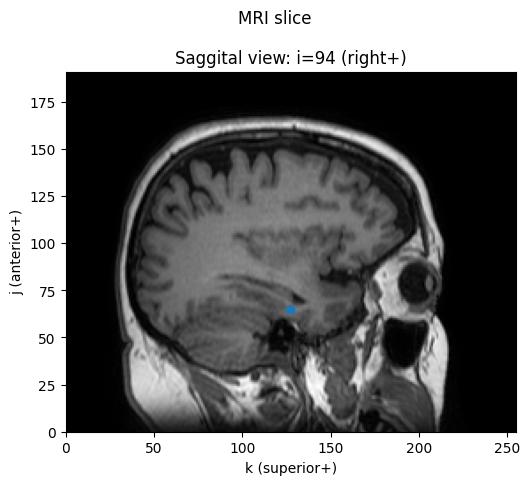

In [22]:
dataplot = np.swapaxes(data, 1, 2)
fig = imshow_mri(dataplot, t1_obj, vox, 'MRI slice')
fig.axes[0].scatter(vox[1],vox[2])

In [5]:
import SimpleITK as sitk
import numpy as np

In [24]:
# First apply affine transform
transform_affine = '/home/mcesped/scratch/code/sEEGPrep/Results/anat_MNI152Asym/work/sub-112/warps/sub-112_desc-ras_from-subject_to-MNI152NLin2009cAsym_affine.txt'
transform_affine= np.linalg.inv(readRegMatrix(transform_affine))
mri_ras_mni_affine = mne.transforms.apply_trans(transform_affine, mri_ras_mm)
mri_ras_mni_affine

array([-33.75524745, -16.80658822, -33.20434765])

In [25]:
# Visualize in MNI space
t1_mni = nb.load('/home/mcesped/scratch/code/sEEGPrep/Results/anat_MNI152Asym/work/sub-112/anat/sub-112_space-MNI152NLin2009cAsym_desc-greedy_T1w.nii.gz')
data_mni = np.asarray(t1_mni.dataobj)

array([ 62, 115,  45])

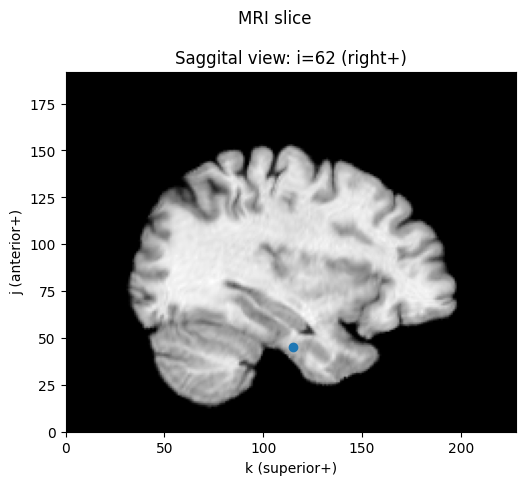

In [27]:
# Transform to voxel
inv_affine = np.linalg.inv(t1_mni.affine)
vox = np.round(mne.transforms.apply_trans(inv_affine, mri_ras_mni_affine)).astype(int)
dataplot = np.swapaxes(data_mni, 1, 2)
fig = imshow_mri(dataplot, t1_mni, vox, 'MRI slice')
fig.axes[0].scatter(vox[1],vox[2])
vox

In [28]:
# Apply non-linear transform
transform_path = '/home/mcesped/scratch/code/sEEGPrep/Results/anat_MNI152Asym/work/sub-112/warps/sub-112_from-subject_to-MNI152NLin2009cAsym_invwarp.nii.gz'
#because we need to take coordinate from native space to MNI we read the inverse matrix
#reads the transform and casts the output compaitble format
transform_image = sitk.ReadImage(transform_path)
transform_image = sitk.Cast(transform_image, sitk.sitkVectorFloat64)

In [29]:
# load it as a transform
identity_transform = sitk.Transform(transform_image)

In [30]:
# Convert point from RAS to LPS
mri_mni_lps = mri_ras_mni_affine * np.array([-1, -1, 1])

In [31]:
mri_mni_lps = identity_transform.TransformPoint(mri_mni_lps)

In [32]:
# Convert from LPS back to RAS
mri_mni = mri_mni_lps * np.array([-1, -1, 1])
mri_mni

array([-34.44510554, -16.40670127, -27.06490548])

array([ 62, 116,  51])

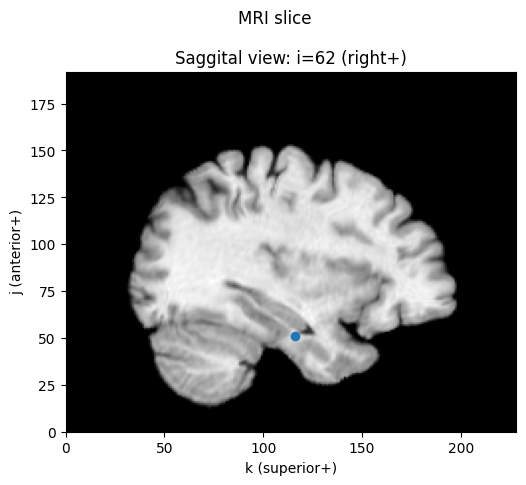

In [33]:
# Transform to voxel
inv_affine = np.linalg.inv(t1_mni.affine)
vox = np.round(mne.transforms.apply_trans(inv_affine, mri_mni)).astype(int)
dataplot = np.swapaxes(data_mni, 1, 2)
fig = imshow_mri(dataplot, t1_mni, vox, 'MRI slice')
fig.axes[0].scatter(vox[1],vox[2])
vox

## MNE montage

In [4]:
def get_chn_labels(chn_csv_path, electrodes_edf):
    """Gets label for each electrode.
    Parameters
    ----------
    ch_csv_path : str
        Path to csv containing electrodes positions.

    Returns : list with labels.
    -------
        
    """
    elec_info = pd.read_csv(chn_csv_path, sep='\t')
    labels_csv = elec_info['label'].values.tolist()
    # Filter to get only labels that are also in edf file
    labels = [label for label in labels_csv if label in electrodes_edf]
    return labels

In [30]:
def get_chn_positions(chn_csv_path, electrodes_edf, tfm_list=None):
    """Creates dictionary with the position of each electrode.
    Parameters
    ----------
    ch_csv_path : str
        Path to csv containing electrodes positions.

    Returns : dictionary with position (x,y,z) of each electrode.
    -------
        
    """
    elec_pos = pd.read_csv(chn_csv_path, sep='\t')
    chn_pos = {}
    for i in np.arange(len(elec_pos)):
        label = elec_pos.loc[[i], ['label']].values[0][0]
        if label in electrodes_edf:
            pos = elec_pos.loc[[i], ['x','y','z']].values[0]
            for tfm, inv_bool in tfm_list:
                if type(tfm)==str:
                    tfm = readRegMatrix(tfm)
                if inv_bool:
                    tfm = np.linalg.inv(tfm)
                pos = mne.transforms.apply_trans(tfm, pos)
            pos = (pos/1000).tolist()
            chn_pos[label] = pos
    return chn_pos

In [6]:
# Open edf file
edf_in = pyedflib.EdfReader('/home/mcesped/projects/ctb-akhanf/cfmm-bids/Khan/epi_iEEG/ieeg/bids/sub-076/ses-001/ieeg/sub-076_ses-001_task-full_run-01_ieeg.edf')
# Extract labels
labels = edf_in.getSignalLabels()
edf_in.close()

In [7]:
csv_path = '/home/mcesped/projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/seega_coordinates/sub-P076/sub-P076_space-native_SEEGA.tsv'

In [8]:
elec_edf = labels
chn_labels = get_chn_labels(csv_path, elec_edf)

In [9]:
tfm = '/home/mcesped/projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/atlasreg/sub-P076/sub-P076_acq-noncontrast_desc-rigid_from-noncontrast_to-contrast_type-ras_xfm.txt'

In [26]:
# Load reference MRI (non contrast)
# t1 = nb.load('/home/mcesped/projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/atlasreg/sub-P076/sub-P076_T1w.nii.gz')
# mgh = nb.MGHImage(t1.dataobj, t1.affine)
# Torig = mgh.header.get_vox2ras_tkr()
t1 = nb.load('/home/mcesped/projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/fastsurfer/sub-P076/mri/T1.mgz')
Torig = t1.header.get_vox2ras_tkr()
print(t1.affine)
print(Torig)

[[ -1.           0.           0.         126.7440033 ]
 [  0.           0.           1.         -68.37800598]
 [  0.          -1.           0.         162.09759521]
 [  0.           0.           0.           1.        ]]
[[  -1.    0.    0.  128.]
 [   0.    0.    1. -128.]
 [   0.   -1.    0.  128.]
 [   0.    0.    0.    1.]]


In [35]:
# It's necessary to send both the contrast to non-contrast tfm as well as the fs to mri tfms
chn_pos = get_chn_positions(csv_path, elec_edf, [(tfm, False), (t1.affine, True), (Torig, False)])

In [36]:
chn_pos

{'LACg1': [0.0042103410425295635, 0.03251701289052534, -0.002538732628803757],
 'LACg2': [-0.0005640802918844372,
  0.03401986478448532,
  -0.0026290977440517624],
 'LACg3': [-0.004959508641784425, 0.03550346203168533, -0.0026771767252297424],
 'LACg4': [-0.009825459451635453, 0.03660553096272531, -0.003332818663485739],
 'LACg5': [-0.01462874944133543, 0.03800728102252532, -0.0033689170254637586],
 'LACg6': [-0.01929802900676043, 0.03928947159212532, -0.003624351692289764],
 'LACg7': [-0.024050208351530444, 0.04042050064852532, -0.0044759571123397564],
 'LACg8': [-0.028982685772236436, 0.04156744050636533, -0.004525323653775757],
 'LACg9': [-0.033490328597487434, 0.04317154314760529, -0.004720665152469763],
 'LACg10': [-0.03820277520658743, 0.04534769705780531, -0.00481607082533975],
 'LAHc1': [-0.024670482561478423,
  -0.0051189354753546894,
  -0.020244144874241754],
 'LAHc2': [-0.027976362866578428,
  -0.0033585563639546906,
  -0.02032858313017576],
 'LAHc3': [-0.03176602303727242, 

In [37]:
subject = 'sub-P076'
subjects_dir = '/home/mcesped/projects/ctb-akhanf/cfmm-bids/Khan/clinical_imaging/epi_iEEG/derivatives/fastsurfer/'

In [38]:
subj_trans = mne.coreg.estimate_head_mri_t(subject, subjects_dir)
mri_to_head_trans = mne.transforms.invert_transform(subj_trans)
print('Start transforming mri to head')
print(mri_to_head_trans)

# chn_pos has to be in mm but in freesurfer space!!
montage_mri = mne.channels.make_dig_montage(chn_pos, coord_frame='mri')
montage = montage_mri.copy()
montage.add_estimated_fiducials(subject, subjects_dir)
montage.get_positions()

Start transforming mri to head
<Transform | MRI (surface RAS)->head>
[[ 0.98762593 -0.15676549  0.00442863  0.00098057]
 [ 0.15682079  0.9874578  -0.01828459  0.01934769]
 [-0.00150669  0.01875284  0.99982301  0.04214381]
 [ 0.          0.          0.          1.        ]]


{'ch_pos': OrderedDict([('LACg1',
               array([ 0.00421034,  0.03251701, -0.00253873])),
              ('LACg2', array([-0.00056408,  0.03401986, -0.0026291 ])),
              ('LACg3', array([-0.00495951,  0.03550346, -0.00267718])),
              ('LACg4', array([-0.00982546,  0.03660553, -0.00333282])),
              ('LACg5', array([-0.01462875,  0.03800728, -0.00336892])),
              ('LACg6', array([-0.01929803,  0.03928947, -0.00362435])),
              ('LACg7', array([-0.02405021,  0.0404205 , -0.00447596])),
              ('LACg8', array([-0.02898269,  0.04156744, -0.00452532])),
              ('LACg9', array([-0.03349033,  0.04317154, -0.00472067])),
              ('LACg10', array([-0.03820278,  0.0453477 , -0.00481607])),
              ('LAHc1', array([-0.02467048, -0.00511894, -0.02024414])),
              ('LAHc2', array([-0.02797636, -0.00335856, -0.02032858])),
              ('LAHc3', array([-0.03176602, -0.00186938, -0.02176008])),
              ('LAHc4', a

In [39]:
montage.apply_trans(mri_to_head_trans)
montage.get_positions()

{'ch_pos': OrderedDict([('LACg1',
               array([3.00259129e-05, 5.21635580e-02, 4.02089737e-02])),
              ('LACg2', array([-0.00492131,  0.05290048,  0.040154  ])),
              ('LACg3', array([-0.00949514,  0.05367706,  0.04014037])),
              ('LACg4', array([-0.01447655,  0.05401421,  0.03951285])),
              ('LACg5', array([-0.01944031,  0.05464578,  0.03951028])),
              ('LACg6', array([-0.02425395,  0.05518432,  0.03928597])),
              ('LACg7', array([-0.0291284 ,  0.0555715 ,  0.03846288])),
              ('LACg8', array([-0.03417986,  0.05593144,  0.03844247])),
              ('LACg9', array([-0.03888406,  0.0568121 ,  0.03828403])),
              ('LACg10', array([-0.04387976,  0.0582237 ,  0.03823655])),
              ('LAHc1', array([-0.02267182,  0.01079427,  0.02184443])),
              ('LAHc2', array([-0.02621313,  0.01201568,  0.021798  ])),
              ('LAHc3', array([-0.03019569,  0.01291806,  0.02040039])),
              ('

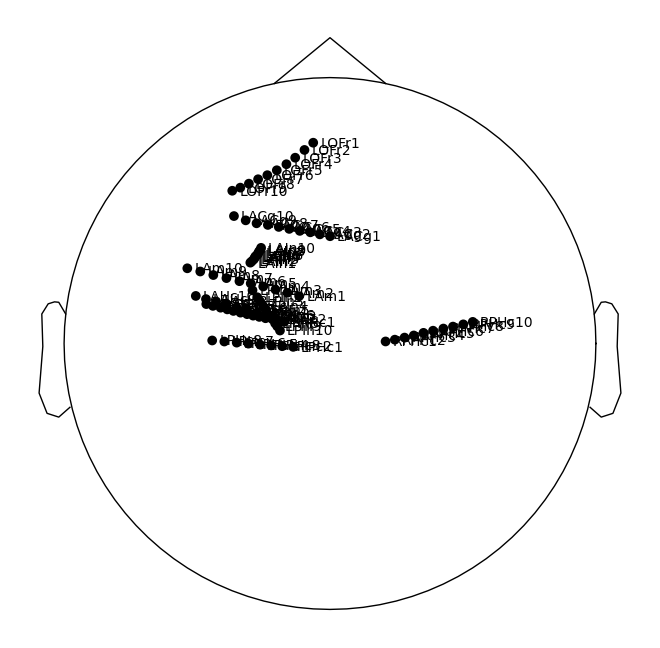

In [40]:
fig = montage.plot(kind="topomap", show=True)
# fig = fig.gca().view_init(azim=40, elev=25)

In [21]:
fiducials = mne.coreg.get_mni_fiducials(subject, subjects_dir=subjects_dir)
nasion_mri = [d for d in fiducials if d["ident"] == FIFF.FIFFV_POINT_NASION][0]# FIFFV_POINT_LPA
print(nasion_mri)  # note it's in Freesurfer MRI coords

<DigPoint |     Nasion : (12.5, 84.0, -43.7) mm    : MRI (surface RAS) frame>


In [18]:
data = np.asarray(t1.dataobj)
print(data.shape)

(256, 256, 256)


In [22]:
nasion_mri_mm = nasion_mri["r"] * 1000  # meters → millimeters
nasion_vox = np.round(mne.transforms.apply_trans(np.linalg.inv(Torig), nasion_mri_mm)).astype(int)
nasion_vox

array([115, 172, 212])

In [25]:
nasion_mri_ras = mne.transforms.apply_trans(t1.affine, nasion_vox)
nasion_mri_ras

array([ 11.7440033 , 143.62199402,  -9.90240479])

In [23]:
# Nasion in head 
mne.transforms.apply_trans(mri_to_head_trans, nasion_mri["r"])

array([ 1.23599048e-17,  1.05070391e-01, -6.93889390e-18])

In [ ]:
nasion_mri

In [ ]:
dataplot = data#np.swapaxes(data, 1, 2)
fig = imshow_mri(
    dataplot, t1, nasion_vox, "Nasion estimated from MRI transform"
)
fig.axes[0].scatter(nasion_vox[2],nasion_vox[1])

In [41]:
import os
print(os.path.join('/home/mcesped/projects/ctb-akhanf/cfmm-bids/Khan//clinical_imaging/epi_iEEG/derivatives/fastsurfer', 'sub-P076', 'mri/T1.mgz'))

/home/mcesped/projects/ctb-akhanf/cfmm-bids/Khan//clinical_imaging/epi_iEEG/derivatives/fastsurfer/sub-P076/mri/T1.mgz
